In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

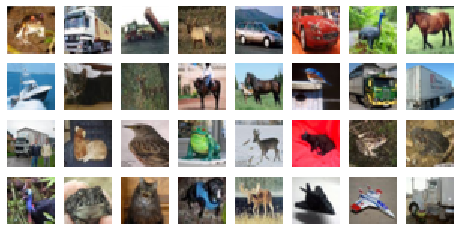

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

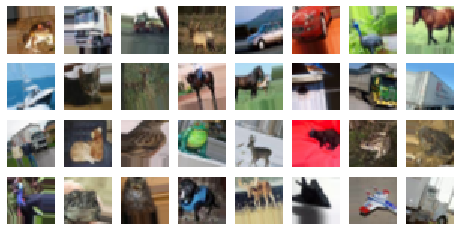

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

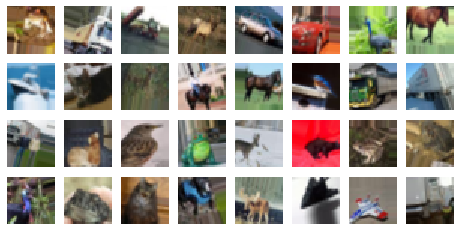

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

*Horizontal Flip, Width Shift, Height Shift, ZCA whitening* <br>
[CIFAR-10 ResNet Keras](https://keras.io/examples/cifar10_resnet/)

In [8]:
num_classes = 10
batch_size = 64
num_epochs = 100

In [9]:
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Model


base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(32,32,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
y = Dropout(0.5)(x)


preds = Dense(10, activation='softmax', kernel_initializer='he_normal')(y)

model = Model(inputs=base_model.input, outputs=preds)
model.summary()

C:\Users\YanRoo\Anaconda3\envs\Keras\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]

In [10]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
subtract_pixel_mean = True
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input

# preprocessing image and divide validaiton set
train_datagen=ImageDataGenerator(preprocessing_function=None, horizontal_flip=True,
                                 width_shift_range=0.1, height_shift_range=0.1,
                                 validation_split=0.08)

validation_datagen=ImageDataGenerator(preprocessing_function=None, validation_split=0.08)


train_generator=train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True, subset='training')

validation_generator=validation_datagen.flow(x_train, y_train, batch_size=batch_size, subset='validation')


In [12]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

checkpoint = ModelCheckpoint(filepath='./best.m5',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

tbCallBack = TensorBoard(log_dir='./logs',
            histogram_freq=0,
            batch_size=batch_size,
            write_graph=True,
            write_grads=True,
            write_images=True,
            update_freq='epoch')

callbacks = [checkpoint, lr_reducer, tbCallBack]

In [13]:
from keras import optimizers
# Use default adam optimizer (learning rate=1e-3, decay=0)
# Loss function: categorical cross entropy
# Evaluation: Accuracy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


step_size_train = train_generator.n // train_generator.batch_size
step_size_val = validation_generator.n // validation_generator.batch_size

history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train,
                              validation_data=validation_generator, validation_steps=step_size_val,
                              epochs=num_epochs, callbacks=callbacks)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
718/718 [==============================] - 95s 132ms/step - loss: 2.1705 - acc: 0.3036 - val_loss: 2.4140 - val_acc: 0.1537

Epoch 00001: val_acc improved from -inf to 0.15373, saving model to ./best.m5
Epoch 2/100
718/718 [==============================] - 85s 119ms/step - loss: 2.3613 - acc: 0.1884 - val_loss: 2.0560 - val_acc: 0.2650

Epoch 00002: val_acc improved from 0.15373 to 0.26499, saving model to ./best.m5
Epoch 3/100
718/718 [==============================] - 83s 115ms/step - loss: 2.1561 - acc: 0.2572 - val_loss: 3.4035 - val_acc: 0.2401

Epoch 00003: val_acc did not improve from 0.26499
Epoch 4/100
718/718 [==============================] - 86s 120ms/step - loss: 1.9421 - acc: 0.3469 - val_loss: 1.6534 - val_acc: 0.3895

Epoch 00004: val_acc improved from 0.26499 to 0.38948, saving model to ./best.m5
Epoch 5/100
718/718 [==============================] - 86s 120ms/

718/718 [==============================] - 83s 115ms/step - loss: 0.7216 - acc: 0.7494 - val_loss: 0.7293 - val_acc: 0.7574

Epoch 00036: val_acc improved from 0.74517 to 0.75737, saving model to ./best.m5
Epoch 37/100
718/718 [==============================] - 82s 115ms/step - loss: 0.6973 - acc: 0.7581 - val_loss: 0.6918 - val_acc: 0.7571

Epoch 00037: val_acc did not improve from 0.75737
Epoch 38/100
718/718 [==============================] - 83s 115ms/step - loss: 0.6869 - acc: 0.7632 - val_loss: 0.7042 - val_acc: 0.7637

Epoch 00038: val_acc improved from 0.75737 to 0.76372, saving model to ./best.m5
Epoch 39/100
718/718 [==============================] - 83s 115ms/step - loss: 0.6613 - acc: 0.7712 - val_loss: 0.7172 - val_acc: 0.7579

Epoch 00039: val_acc did not improve from 0.76372
Epoch 40/100
718/718 [==============================] - 83s 116ms/step - loss: 0.6453 - acc: 0.7764 - val_loss: 0.6362 - val_acc: 0.7861

Epoch 00040: val_acc improved from 0.76372 to 0.78608, saving

718/718 [==============================] - 84s 117ms/step - loss: 0.3230 - acc: 0.8861 - val_loss: 0.5907 - val_acc: 0.8087

Epoch 00078: val_acc did not improve from 0.81860
Epoch 79/100
718/718 [==============================] - 84s 117ms/step - loss: 0.3304 - acc: 0.8842 - val_loss: 0.5737 - val_acc: 0.8206

Epoch 00079: val_acc improved from 0.81860 to 0.82063, saving model to ./best.m5
Epoch 80/100
718/718 [==============================] - 84s 116ms/step - loss: 0.3247 - acc: 0.8855 - val_loss: 0.6027 - val_acc: 0.8125

Epoch 00080: val_acc did not improve from 0.82063
Epoch 81/100
718/718 [==============================] - 84s 117ms/step - loss: 0.3269 - acc: 0.8860 - val_loss: 0.5764 - val_acc: 0.8150

Epoch 00081: val_acc did not improve from 0.82063
Epoch 82/100
718/718 [==============================] - 84s 117ms/step - loss: 0.3176 - acc: 0.8878 - val_loss: 0.5907 - val_acc: 0.8117

Epoch 00082: val_acc did not improve from 0.82063
Epoch 83/100
718/718 [====================

In [14]:
model.load_weights('./best.m5')

In [15]:
test_datagen=ImageDataGenerator()
test_generator=validation_datagen.flow(x_test, y_test)

scores = model.evaluate_generator(test_generator)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.6299271319866181
Test accuracy: 0.8032
